## Trajectory analysis  for MD Simulation from Folding Trp-Cage Peptide

    Reproduce some analysis in http://ambermd.org/tutorials/basic/tutorial3/section6.htm

## Download data

```
url: http://ambermd.org/tutorials/basic/tutorial3/section6.htm
```

### Require
- pytraj/cpptraj
- nglview (https://github.com/arose/nglview)
    ```bash
          # Linux users
          conda install -c ambermd nglview
          
          # for Mac user, please see the instruction from above website
    ```
    
- pandas

    ```bash
         conda install pandas
    ```

In [1]:
# uncomment below to download, untar files.

#!wget http://ambermd.org/tutorials/basic/tutorial3/files/production.tar.gz
#!wget http://ambermd.org/tutorials/basic/tutorial3/files/TC5b.prmtop
#!mv TC5b.prmtop production/
#!tar -xf ./production.tar.gz
#! wget http://ambermd.org/tutorials/basic/tutorial3/files/lowest_energy_struct.pdb.2455 production/
# !mv lowest_energy_struct.pdb.2455 production/
!ls production/

equil10.mdcrd.gz  equil3.rst	   equil7.out
equil10.out	  equil4.mdcrd.gz  equil7.rst
equil10.rst	  equil4.out	   equil8.mdcrd.gz
equil1.mdcrd.gz   equil4.rst	   equil8.out
equil1.out	  equil5.mdcrd.gz  equil8.rst
equil1.rst	  equil5.out	   equil9.mdcrd.gz
equil2.mdcrd.gz   equil5.rst	   equil9.out
equil2.out	  equil6.mdcrd.gz  equil9.rst
equil2.rst	  equil6.out	   lowest_energy_struct.pdb.2455
equil3.mdcrd.gz   equil6.rst	   TC5b.prmtop
equil3.out	  equil7.mdcrd.gz


## Load trajectory files by pytraj

In [2]:
import pytraj as pt
traj = pt.load('production/equil*.mdcrd.gz', top='production/TC5b.prmtop')
traj

pytraj.Trajectory, 50000 frames: 
Size: 0.339746 (GB)
<Topology: 304 atoms, 20 residues, 1 mols, non-PBC>
           

## Visualization with nglview

In [3]:
# note: you need to run the notebook
import nglview as nv

view = nv.show_pytraj(traj)
view

In [4]:
# reset representation
view.representations = []
view.parameters = {'theme': 'dark'}
view.add_representation('licorice', selection='not hydrogen')
view.add_representation('cartoon')

In [5]:
# jump to specific frame
view.frame = 2000

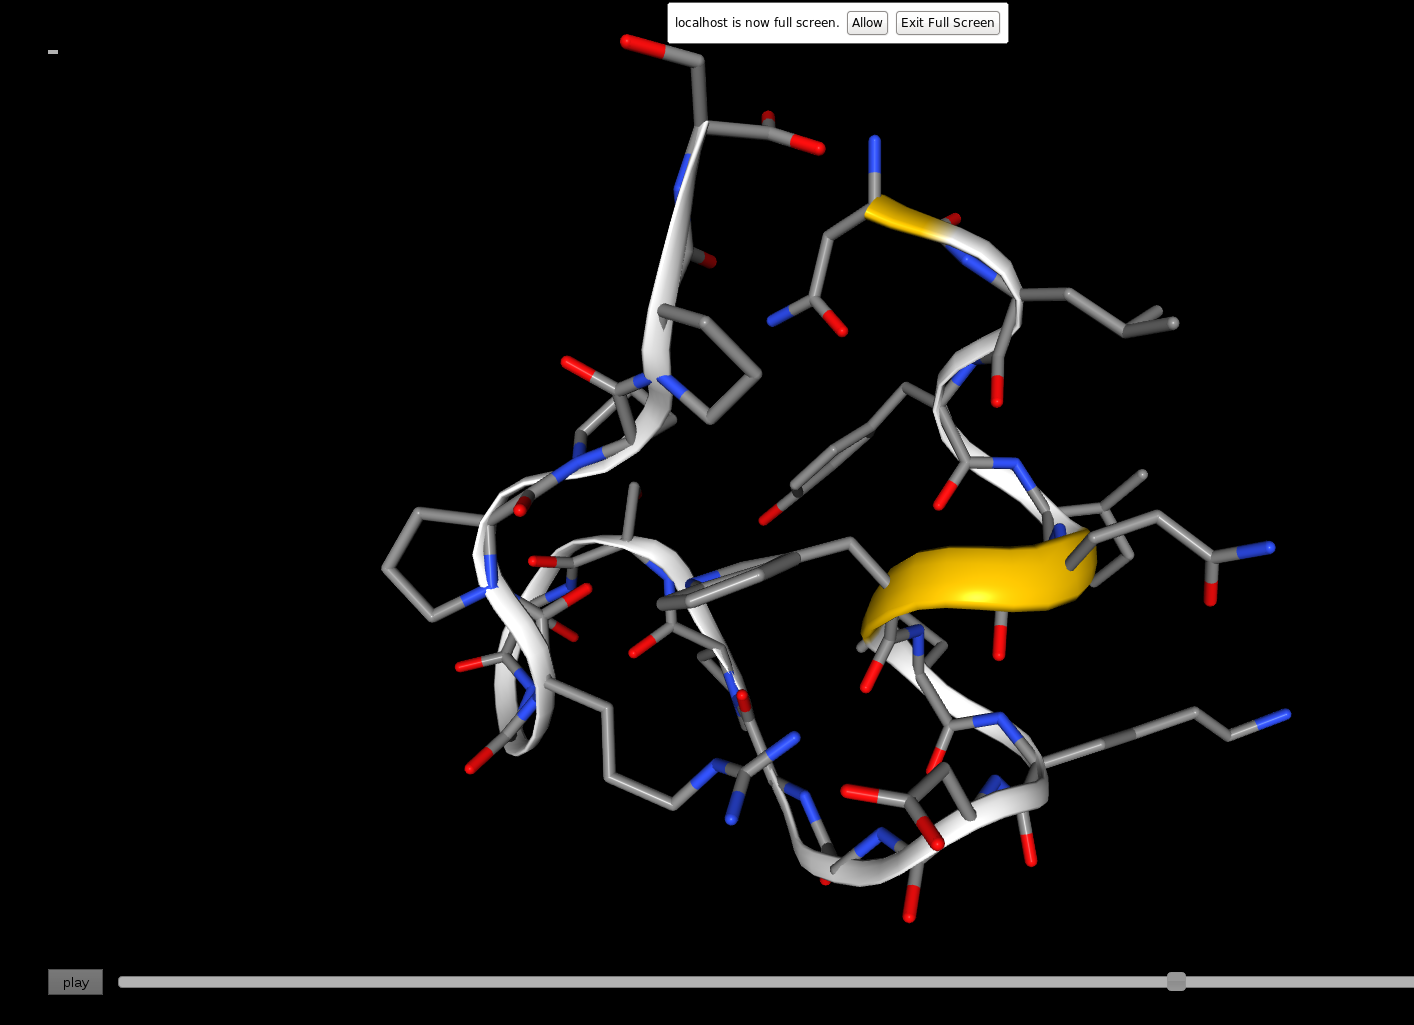

In [6]:
# if you're using notebook, you should see somethinge similiar to below image
from IPython.display import Image
Image('nglview_trpcage_amber_tutorial_3.png', width=600)

## Plot RMSD vs time to lowest structure (taken from tutorial)

In [7]:
# load reference (we don't need to use a topology file since this is pdb)
lowest_energy_pdb = pt.load('production/lowest_energy_struct.pdb.2455')
lowest_energy_pdb

pytraj.Trajectory, 1 frames: 
Size: 0.000007 (GB)
<Topology: 304 atoms, 20 residues, 1 mols, non-PBC>
           

In [8]:
rmsd_to_lowest_pdb = pt.rmsd(traj, ref=lowest_energy_pdb, mask='@N,CA,C')
rmsd_to_lowest_pdb

array([ 5.27339494,  5.14608589,  4.98715608, ...,  3.73567383,
        3.52249127,  3.46483843])

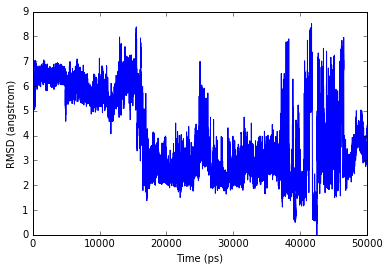

In [9]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.plot(rmsd_to_lowest_pdb)
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (angstrom)')

## Compute dihedral angle for TRP6

In [10]:

# store data in pandas's DataFrame
# 
df_trp6_dihedrals = pt.multidihedral(traj, resrange='6', dtype='dataframe')
df_trp6_dihedrals.head(6)

,phi_6,psi_6,chip_6,omega_6
0,-76.611207,151.569302,-171.449215,-178.380826
1,-73.083864,169.196403,-163.917153,-175.234276
2,-141.113262,160.778650,-155.444528,-177.581732
3,-141.529617,150.066684,176.778163,-167.869044
4,-131.870487,134.767010,-159.404503,168.943205
5,-166.370848,156.078155,153.671127,-171.181556


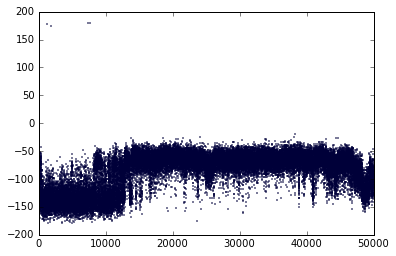

In [11]:
plt.plot(df_trp6_dihedrals['phi_6'], 'bo', markersize=1.)

# Hbond

In [12]:
hbond_data = pt.hbond(traj)
hbond_data

<pytraj.hbonds.DatasetHBond
donor_aceptor pairs : 486>

In [13]:
## Get donor and acceptor mask, only show first 10
hbond_data.donor_aceptor[:10]

['ASN1_OD1-LEU2_N-H',
 'LYS8_O-GLY11_N-H',
 'ARG16_O-ARG16_NE-HE',
 'ARG16_O-ARG16_NH2-HH21',
 'PRO12_O-GLY15_N-H',
 'GLY10_O-ARG16_NH2-HH21',
 'ASP9_OD1-GLY10_N-H',
 'PRO12_O-SER14_N-H',
 'PRO17_O-ARG16_NE-HE',
 'PRO17_O-ARG16_NH2-HH21']

## plot total hbond number vs rmsd

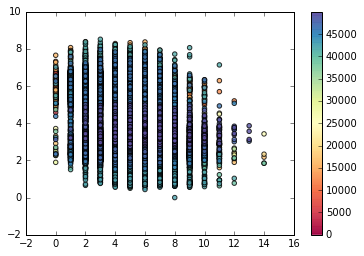

In [14]:
# plot total hbond number vs rmsd
# color by frame number
n_hbonds_per_frame = hbond_data.total_solute_hbonds()
fig = plt.scatter(n_hbonds_per_frame, rmsd_to_lowest_pdb, 
                  marker='o', c=range(traj.n_frames), alpha=0.8, cmap='Spectral')
plt.colorbar()

In [15]:
# get distance and angle mask for each hbond
h_dist_mask, h_angle_mask = hbond_data.get_amber_mask()
print(h_dist_mask)
print(h_angle_mask)

[':1@OD1 :2@H' ':8@O :11@H' ':16@O :16@HE' ..., ':16@O :14@H' ':1@O :20@H'
 ':5@NE2 :1@HD22']
[':1@OD1 :2@H :2@N' ':8@O :11@H :11@N' ':16@O :16@HE :16@NE' ...,
 ':16@O :14@H :14@N' ':1@O :20@H :20@N' ':5@NE2 :1@HD22 :1@ND2']


In [16]:
# compute hbond distance
# use dtype='dataframe' to dump distance data to pandas' DataFrame
h_dist = pt.distance(traj, h_dist_mask, dtype='dataframe')

# need to update mask
h_dist.columns = h_dist_mask

In [17]:
# just want to show some data
h_dist[[':1@OD1 :2@H', ':8@O :11@H', ':16@O :16@HE']].head(5)

,:1@OD1 :2@H,:8@O :11@H,:16@O :16@HE
0,2.031473,1.959615,3.494677
1,3.711942,2.547225,1.944752
2,2.531966,2.664229,2.016934
3,3.249249,2.672545,5.467710
4,2.917321,3.800039,4.817248


In [18]:
# stats
h_dist.describe()

,:1@OD1 :2@H,:8@O :11@H,:16@O :16@HE,:16@O :16@HH21,:12@O :15@H,:10@O :16@HH21,:9@OD1 :10@H,:12@O :14@H,:17@O :16@HE,:17@O :16@HH21,...,:11@O :16@H,:5@O :16@HH11,:18@O :6@HE1,:11@O :15@H,:2@O :20@H,:14@O :11@H,:6@NE1 :20@H,:16@O :14@H,:1@O :20@H,:5@NE2 :1@HD22
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3.497438,5.384411,5.260892,6.871186,2.691470,7.896430,4.806445,3.000442,5.842839,7.049697,...,5.549820,8.618404,7.901075,5.742750,13.030228,9.994091,9.978559,5.875091,14.339777,10.340851
std,0.983849,1.442871,1.389453,1.577477,1.071461,3.972324,0.649736,0.435496,1.868090,2.357809,...,1.432182,2.059423,3.230941,1.008086,4.562747,1.412447,3.241633,1.054174,6.022885,3.226749
min,1.644560,1.811608,1.648349,1.995952,1.622839,1.624577,1.690438,1.635916,1.619257,1.595782,...,1.682516,1.808268,1.703661,1.759154,1.874620,1.888668,1.926273,1.959305,1.723943,2.123781
25%,2.724144,4.646580,4.074415,5.558070,2.077899,5.296069,4.376737,2.752425,4.866850,5.930966,...,4.566259,7.513432,5.993242,5.342290,9.303610,9.648259,7.749804,5.302430,8.373914,8.132758
50%,3.305591,5.598265,5.260824,6.857723,2.288898,6.160766,4.955284,3.019603,5.869063,6.964953,...,5.203775,8.466327,7.008542,5.636099,12.583573,10.251976,9.429277,5.725180,14.116375,10.212492
75%,4.291924,6.154997,6.261976,7.981071,2.709509,9.530538,5.290851,3.270971,7.223211,8.783462,...,6.567888,9.322821,8.569227,5.995614,16.627177,10.734142,11.331592,6.299126,19.487733,12.577430
max,6.212335,9.442201,8.120241,9.947891,8.757400,20.005378,6.466101,5.331711,10.150820,11.768551,...,10.954459,23.759383,25.077294,10.817565,30.668472,13.954714,25.387879,10.497357,33.255347,22.130377


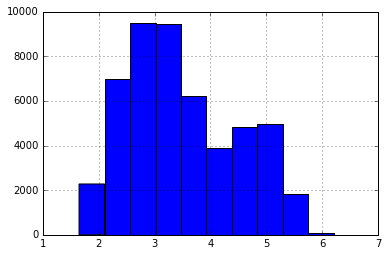

In [19]:
# plot
h_dist[':1@OD1 :2@H'].hist()

In [20]:
h_dist[':1@OD1 :2@H'].describe()

count    50000.000000
mean         3.497438
std          0.983849
min          1.644560
25%          2.724144
50%          3.305591
75%          4.291924
max          6.212335
Name: :1@OD1 :2@H, dtype: float64